In [1]:
# This is not my original work!  
# I make no claims, other than to stand on the shoulders of other geniuses.

# I am just recreating the fabulous documentation found at https://www.nakka-rocketry.net/.  If you like model rocketry, and want to learn more about DIY motors, this page goes deep into the math and theory.

Text(0, 0.5, 'Kn')

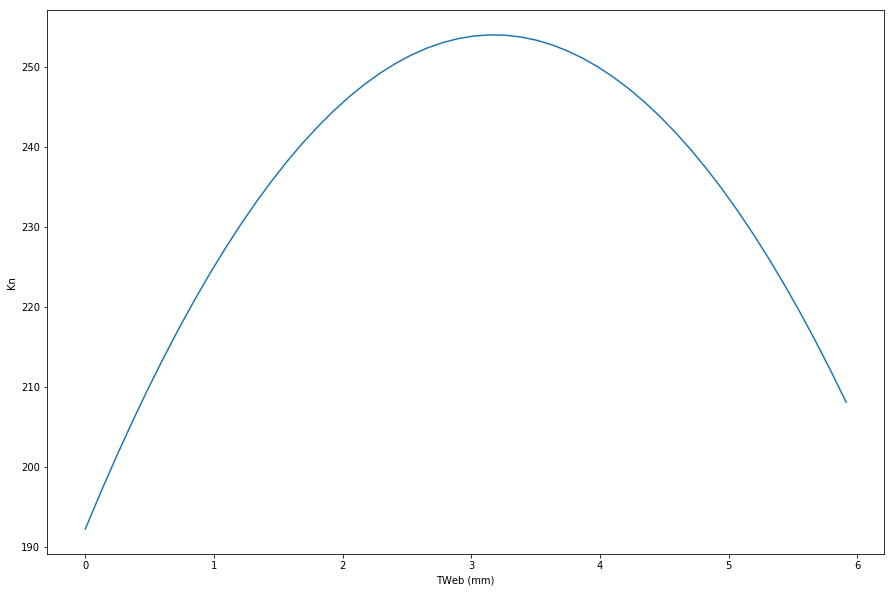

In [2]:
import numpy as np
import math
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.optimize as opt

plt.rcParams['figure.figsize'] = [15, 10]

def circleArea(do,di=0):
    return (math.pi/4) * (do**2-di**2)

def cylinderVolume(h,do,di=0):
    return circleArea(do,di) * h

Do = 15.
Di = 3.175
L = 25.4
Tweb_0 = (Do - Di) / 2

# burn area at Tweb(x)
def Abs_x(x):
    Ab_total = circleArea(Do,Di+2*x)*2 + math.pi*(Di+2*x)*(L-2*x)
    return Ab_total

KnMax = 254

# x is amount burned
x = np.linspace(0,Tweb_0)

# find max Ab
Abs = Abs_x(x)
AbMax=np.amax(Abs)

Ato = AbMax/KnMax
Kn = Abs/Ato
plt.plot(x,Kn)   
plt.xlabel('TWeb (mm)')
plt.ylabel('Kn')

In [3]:
#Constants
# Uniiversal Gas Constant in m^3 Pa/Mol-K - > m^3-Mpa/Mol-K
Rprime = 8314.
# effective molecular weight in kg/Mol  
M = 41.98
# ratio of specific heats
k = 1.139   
# K Ideal combustion temperature
To = 1720  
# K Actual combustion temperature
To_act = 1634 
# ambient atmospheric pressure (MPa)
Patm = .101
# Ideal propellent density (g/cm^3 -> kg /m^3 )
rho_p = 1.889 * 1000 
# pressure exponent (mm/s)
n = 0.319
# burn rate coefficient (psi -> m/sec-Pa^n)
a = 0.0665 * (1/39.37) * (1/6895**n)


mpa_to_psi = 145.038


The steady-state chamber pressure $P_o(K_n)$ is given by:

$$\Large P_o=\left[K_n \frac{a \rho_p}{\sqrt{\frac{k}{R T_o}\left(\frac{2}{k+1}\right)^\frac{k+1}{k-1}}}\right]^\frac{1}{1-n}$$

Text(0, 0.5, 'Pressure (psi)')

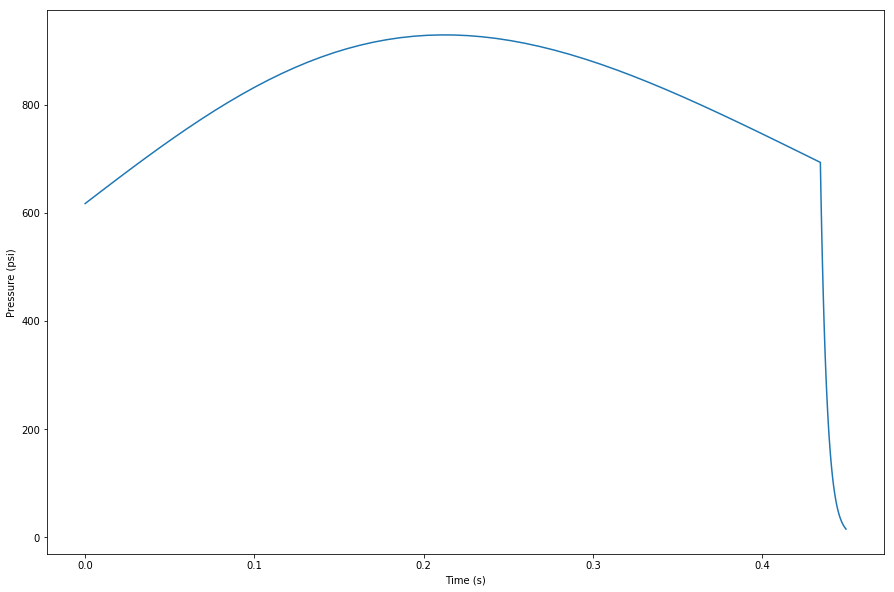

In [4]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 10]
# break this up a bit
R = Rprime/M

Po = ((Kn*a*rho_p)/math.sqrt((k/(To_act*R))*((2/(k+1))**((k+1)/(k-1)))))**(1/(1-n))
Po_psi=mpa_to_psi*Po/1000000

# calculate falloff
Pbo = Po[-1]

cstar = math.sqrt((R*To)/(k*((2/(k+1))**((k+1)/(k-1)))))
#display(cstar)

Uo = cylinderVolume(L/1000,Do/1000);
#display(Uo, Ato)
#display(Patm)
def Pb(t): return (Pbo * np.exp(t * -R * To * Ato/(1000**2 * Uo * cstar))) - Patm*1000000.

end_t = opt.newton(Pb,0) 

x2 = np.linspace(0,end_t)
Px2 = Pb(x2) + Patm*1000000
Px2_psi=mpa_to_psi*Px2/1000000

#burn rate over Po array
r = a*Po**n

#calculate delta time per mm burned
time_intervals=x/(1000*r)
x2 = x2 + time_intervals[-1]

time_intervals = np.concatenate([time_intervals,x2]) 
Po_psi = np.concatenate([Po_psi,Px2_psi])

plt.plot(time_intervals, Po_psi)
plt.xlabel('Time (s)')
plt.ylabel('Pressure (psi)')